This is a project.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mean_absolute_percentage_error
from keras import Model
from keras.layers import Input, Dense, Dropout, LSTM

In [12]:
# Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Using GPU: {device_name}")
else:
    print("Using CPU")

Num GPUs Available:  0
Using CPU


In [149]:
ticker = 'JPY=X'
date_start = '2014-01-01'
date_end = '2023-12-31'

df = yf.download(ticker, start=date_start, end=date_end, interval='1d')
df = df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [151]:
# Calculate Returns (percentage change of the close price)
df['Return'] = df['Close'].pct_change()

# Calculate Rolling Volatility (standard deviation of returns over a window, e.g., 20 days)
df['Volatility'] = df['Return'].rolling(window=20).std()

# Drop missing values (due to rolling window and returns calculation)
df.dropna(inplace=True)

# Normalize the data using StandardScaler
scaler = StandardScaler()
df[['Return', 'Volatility']] = scaler.fit_transform(df[['Return', 'Volatility']])

In [153]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Volatility
20,2014-01-29,103.232002,103.359001,102.029999,103.231003,103.231003,0,0.991245,0.545247
21,2014-01-30,102.239998,102.779999,102.087997,102.300003,102.300003,0,-1.676824,0.662008
22,2014-01-31,102.727997,102.907997,102.014999,102.758003,102.758003,0,0.794361,0.701310
23,2014-02-03,102.237999,102.393997,101.255997,102.192001,102.192001,0,-1.034017,0.730969
24,2014-02-04,101.156998,101.567001,100.783997,101.141998,101.141998,0,-1.906847,0.826121
...,...,...,...,...,...,...,...,...,...
2600,2023-12-25,142.341995,142.479996,142.139008,142.341995,142.341995,0,0.325130,1.420744
2601,2023-12-26,142.229996,142.619995,142.108002,142.229996,142.229996,0,-0.169505,1.381866
2602,2023-12-27,142.460999,142.832001,141.858002,142.460999,142.460999,0,0.271970,1.311107
2603,2023-12-28,141.399002,141.651993,140.289993,141.399002,141.399002,0,-1.390448,1.359048


In [155]:
df.duplicated().sum()

0

In [157]:
df.isnull().sum().sum()

0

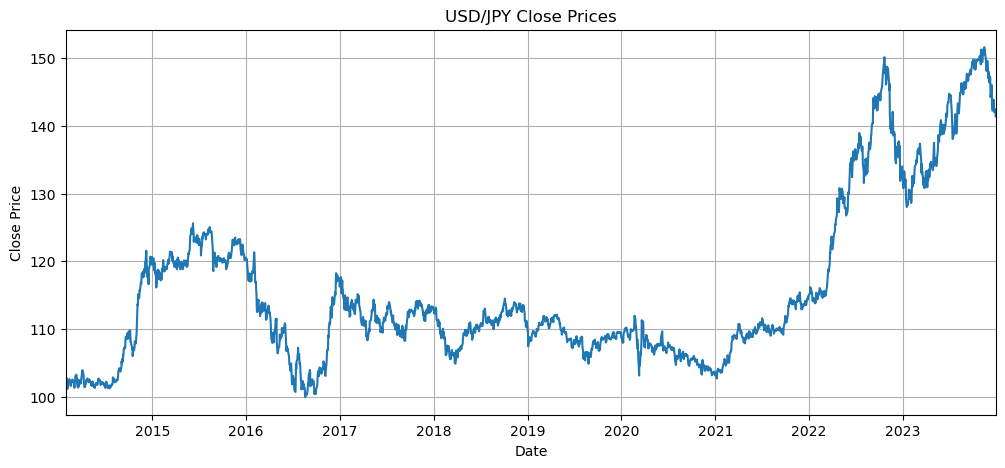

In [159]:
plt.figure(figsize=(12, 5))
plt.plot(df.Date, df.Close)
plt.title('USD/JPY Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(min(df.Date), max(df.Date))
plt.grid(True)
plt.show()

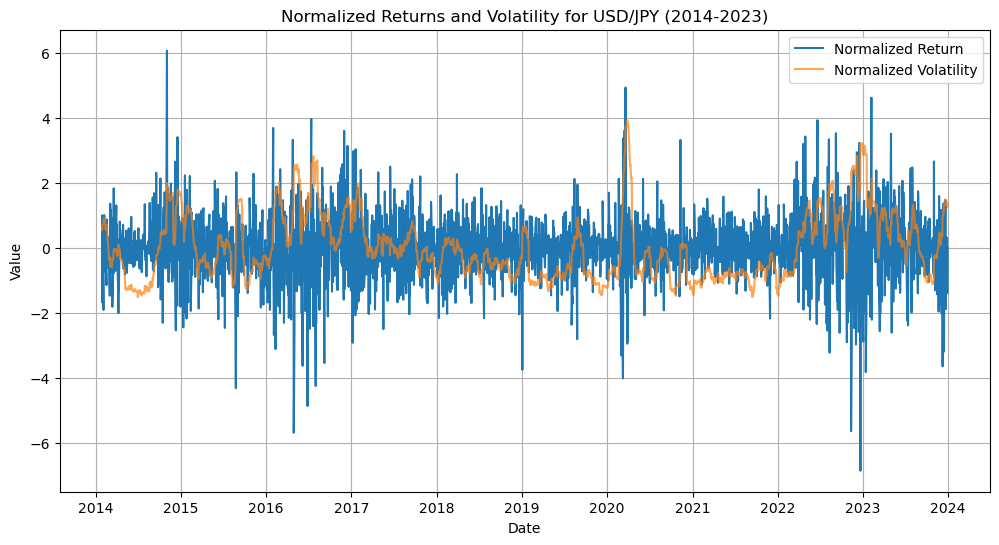

In [161]:
# Visualize the normalized returns and volatility
plt.figure(figsize=(12,6))
plt.plot(df.Date, df['Return'], label='Normalized Return')
plt.plot(df.Date, df['Volatility'], label='Normalized Volatility', alpha=0.7)
plt.title('Normalized Returns and Volatility for USD/JPY (2014-2023)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

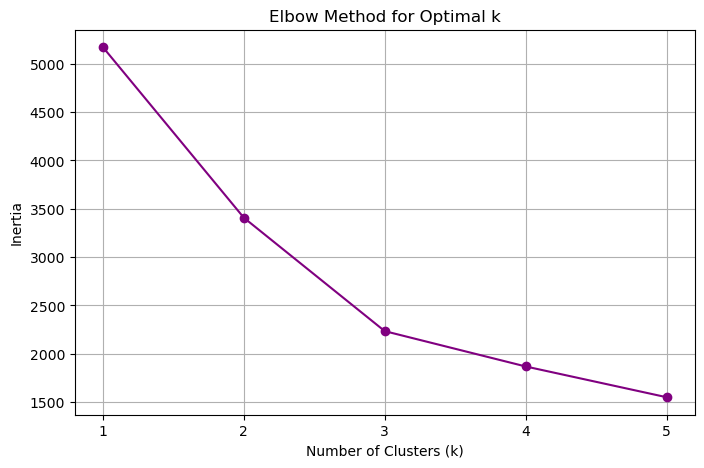

In [163]:
# Use K-Means to identify market regimes
ks = range(1, 6)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df[['Return', 'Volatility']])
    inertias.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(ks, inertias, '-o', color='purple')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(ks)
plt.grid(True)
plt.show()

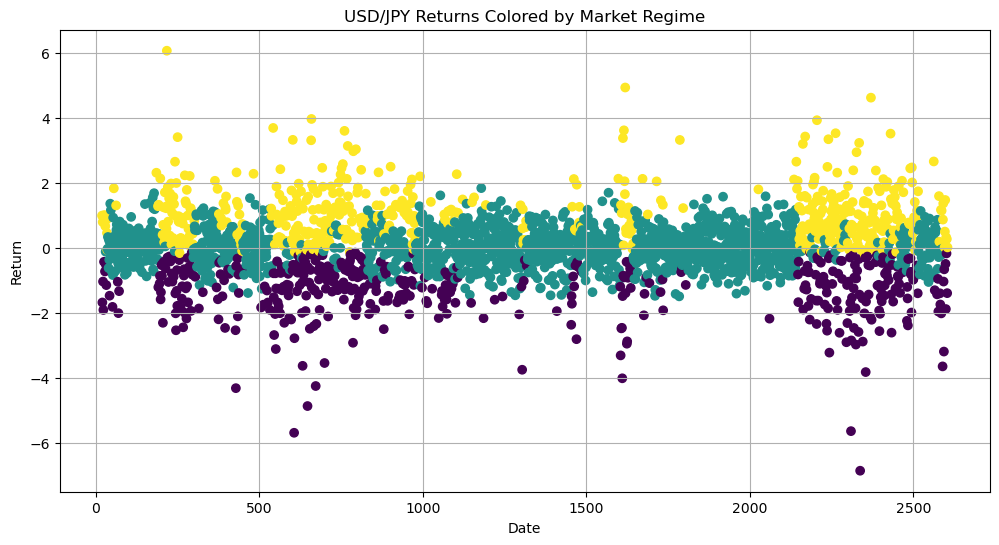

In [165]:
# Fit the K-Means model with the optimal number of clusters (choose k=3 for regimes)
kmeans_model = KMeans(n_clusters=3)
df['Regime'] = kmeans_model.fit_predict(df[['Return', 'Volatility']])

# Plot the clustering results
plt.figure(figsize=(12,6))
plt.scatter(df.index, df['Return'], c=df['Regime'], cmap='viridis', label='Market Regime')
plt.title('USD/JPY Returns Colored by Market Regime')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.show()

Summary of Market Regimes:
          Return  Volatility
Regime                      
0      -1.289302    0.879821
1       0.018848   -0.629750
2       1.030503    1.024512


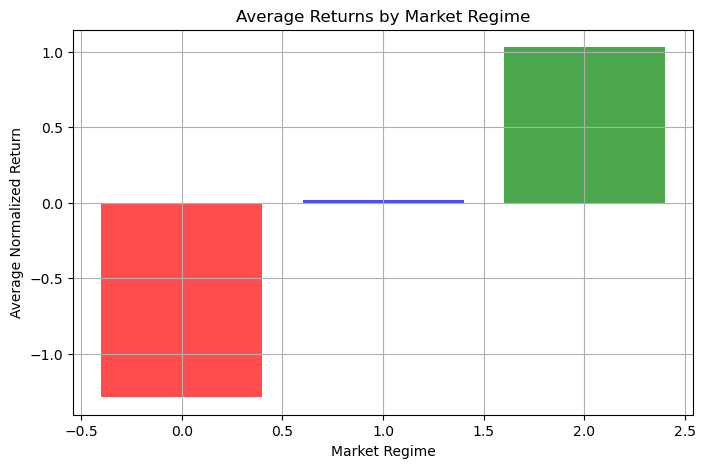

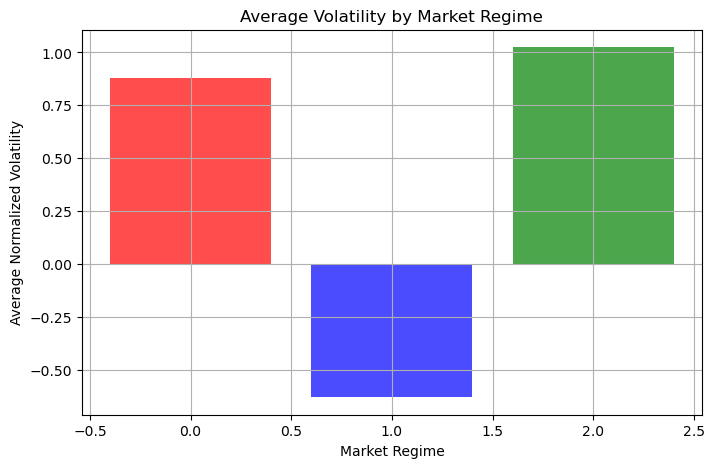

In [167]:
# Analyze the behavior of the market regimes
regime_summary = df.groupby('Regime').mean()[['Return', 'Volatility']]
print("Summary of Market Regimes:")
print(regime_summary)

# Plot the average return and volatility for each regime
plt.figure(figsize=(8,5))
plt.bar(regime_summary.index, regime_summary['Return'], color=['red', 'blue', 'green'], alpha=0.7)
plt.xlabel('Market Regime')
plt.ylabel('Average Normalized Return')
plt.title('Average Returns by Market Regime')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(regime_summary.index, regime_summary['Volatility'], color=['red', 'blue', 'green'], alpha=0.7)
plt.xlabel('Market Regime')
plt.ylabel('Average Normalized Volatility')
plt.title('Average Volatility by Market Regime')
plt.grid(True)
plt.show()

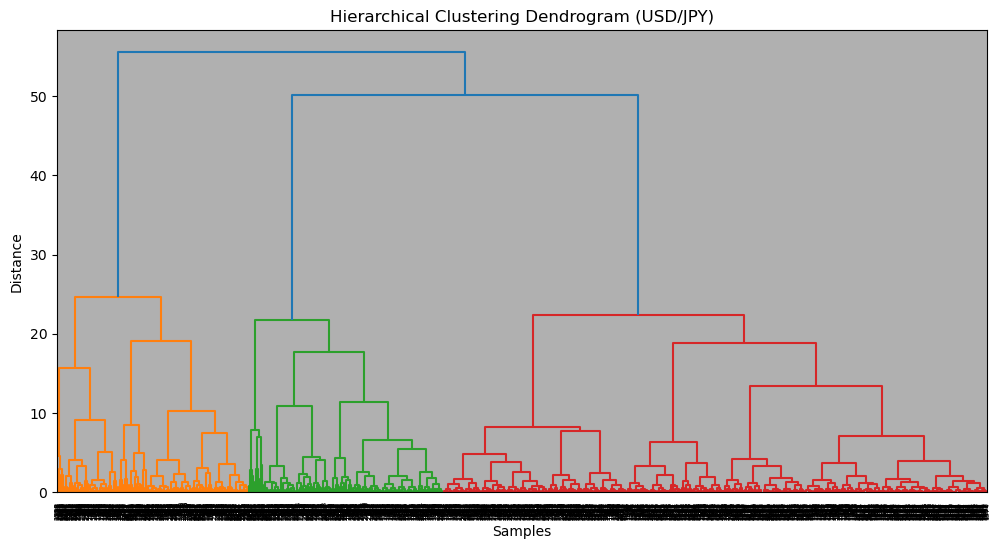

In [169]:
# Perform hierarchical clustering
linked = linkage(df[['Return', 'Volatility']], method='ward')

# Plot the dendrogram
plt.figure(figsize=(12,6))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram (USD/JPY)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

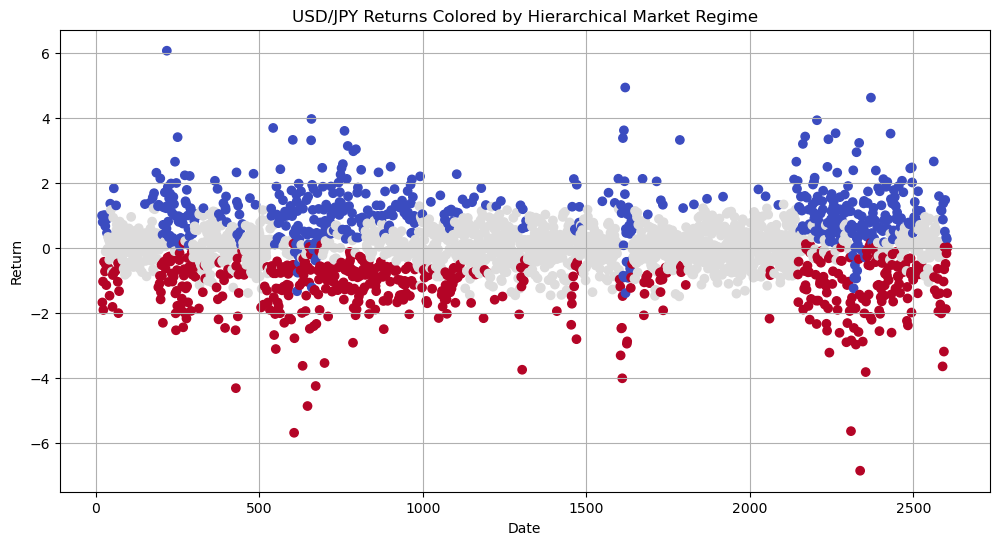

In [266]:
# Fit Agglomerative Clustering with the same number of clusters (k=3)
hierarchical_model = AgglomerativeClustering(n_clusters=3)
df['Hierarchical_Regime'] = hierarchical_model.fit_predict(df[['Return', 'Volatility']])

# Compare K-Means and Hierarchical clustering results
plt.figure(figsize=(12,6))
plt.scatter(df.index, df['Return'], c=df['Hierarchical_Regime'], cmap='coolwarm', label='Hierarchical Regimes')
plt.title('USD/JPY Returns Colored by Hierarchical Market Regime')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.show()

In [270]:
# ---------------------------------------------------------------------------
# LSTM Model incorporating Regime Detection as a feature
# ---------------------------------------------------------------------------

# Prepare data for LSTM model
test_size = df[df.Date.dt.year >= 2023].shape[0]
scaler = MinMaxScaler()

print(test_size)

260


In [272]:
window_size = 60

# Scale the close price and regime features
train_data = df[['Close', 'Regime']][:-test_size]
test_data = df[['Close', 'Regime']][-test_size-window_size:]

train_data['Close_scaled'] = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
test_data['Close_scaled'] = scaler.transform(test_data['Close'].values.reshape(-1,1))

# Prepare data with price and regime
train_data = np.concatenate([train_data['Close_scaled'].values.reshape(-1, 1), train_data['Regime'].values.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_data['Close_scaled'].values.reshape(-1, 1), test_data['Regime'].values.reshape(-1, 1)], axis=1)

In [293]:
window_size = 60

# Scale the close price and regime features
train_data = df[['Close']][:-test_size]
test_data = df[['Close']][-test_size-window_size:]

train_data['Close_scaled'] = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
test_data['Close_scaled'] = scaler.transform(test_data['Close'].values.reshape(-1,1))

# Prepare data with price and regime
train_data = np.concatenate([train_data['Close_scaled'].values.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_data['Close_scaled'].values.reshape(-1, 1)], axis=1)

In [295]:
X_train, y_train = [], []

# Training Set
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i])
    y_train.append(train_data[i, 0])  # Predict the scaled price

# Testing Set
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i])
    y_test.append(test_data[i, 0])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # 2 features: price and regime
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

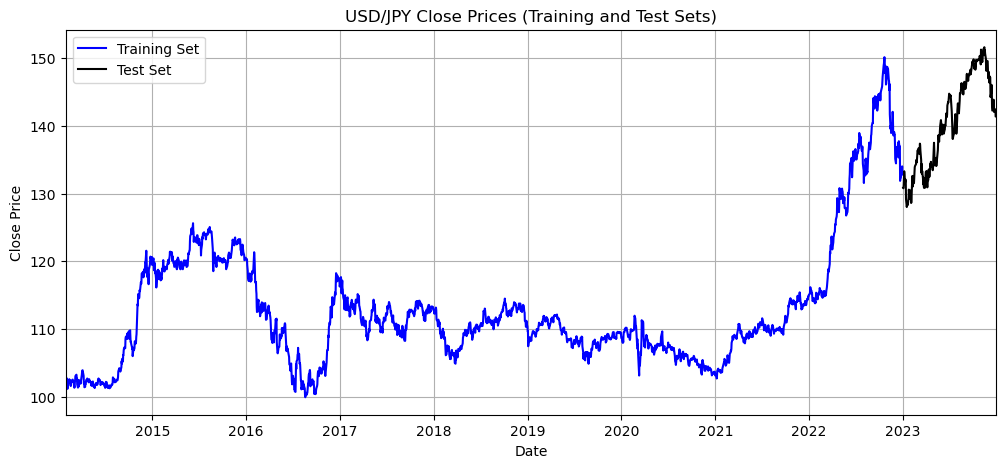

In [297]:
plt.figure(figsize=(12, 5))
plt.plot(df.Date[:-test_size], df.Close[:-test_size], label="Training Set", color='blue')
plt.plot(df.Date[-test_size:], df.Close[-test_size:], label="Test Set", color='black')
plt.title('USD/JPY Close Prices (Training and Test Sets)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(min(df.Date), max(df.Date))
plt.legend()
plt.grid(True)
plt.show()

In [299]:
# Define the LSTM model
def LSTMmodel():
    input1 = Input(shape=(window_size, 1))
    x = LSTM(units=64, return_sequences=True)(input1)  
    x = Dropout(0.25)(x)
    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.25)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)  # Output single price prediction

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

# Train the model
model = LSTMmodel()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0190 - val_loss: 0.1104
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0017 - val_loss: 0.0943
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0012 - val_loss: 0.0860
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012 - val_loss: 0.0837
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0011 - val_loss: 0.0795
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 9.4888e-04 - val_loss: 0.0795
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 9.2657e-04 - val_loss: 0.0764
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 9.2335e-04 - val_loss: 0.0739
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.4855e-04 - val_loss: 0.0725
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.2394e-04 - val_loss: 0.0703
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 7.2562e-04 - val_loss: 0.0702
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 

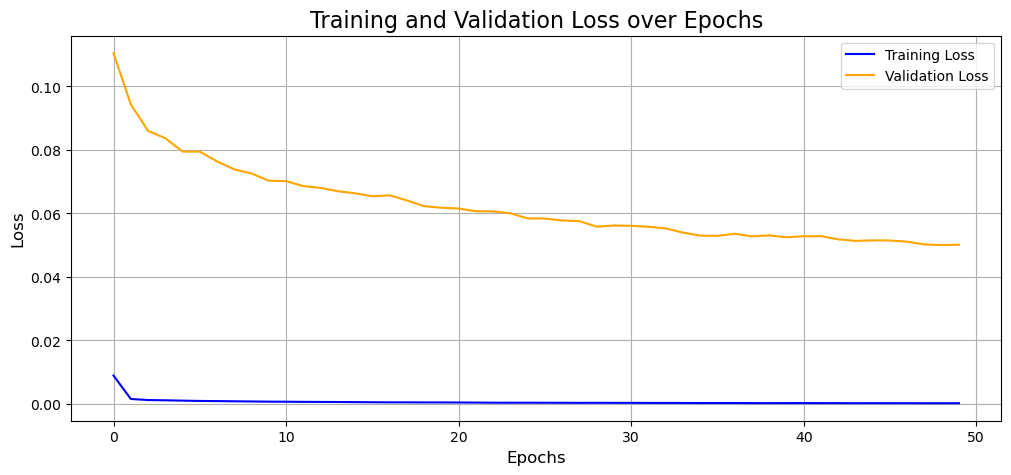

In [300]:
# After training the model, you can access the loss and val_loss from the history object
# history.history is a dictionary that contains the keys 'loss' and 'val_loss'
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [301]:
# Make predictions
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0571
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Loss: 0.0971611887216568
Test MAPE: 0.3312212575922253
Test Accuracy: 0.6687787424077747


In [302]:
# Inverse transform the predictions and training data
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_pred)

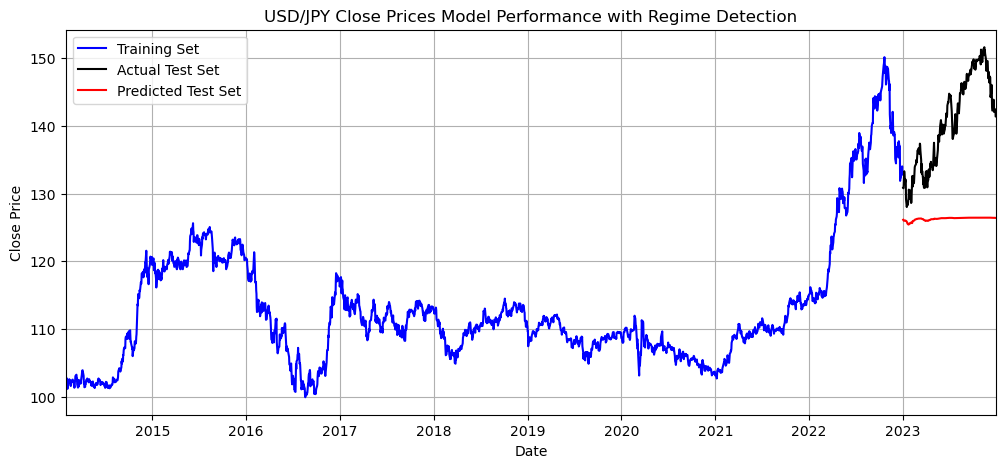

In [303]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(df.Date.iloc[:-test_size], scaler.inverse_transform(train_data), color='blue', label='Training Set')
plt.plot(df.Date.iloc[-test_size:], y_test_true, label="Actual Test Set", color='black')
plt.plot(df.Date.iloc[-test_size:], y_test_pred, label="Predicted Test Set", color='red')
plt.title('USD/JPY Close Prices Model Performance with Regime Detection')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(min(df.Date), max(df.Date))
plt.legend()
plt.grid(True)
plt.show()